<a href="https://colab.research.google.com/github/SEOUL-ABSS/SHIPSHIP/blob/main/SONAR7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) 환경설정/설치 중 ...

2) 데이터 확보 ...
 - DeepShip 이미 존재
[TIMER] DeepShip clone: 0.00s | RSS≈1.42 GB
 - MBARI OK (이미 10개 존재)
[TIMER] MBARI fetch (최대 10개): 0.00s | RSS≈1.42 GB

[세그 생성] DeepShip ...
 - DeepShip 파일:63 | ship:1390 | noise:0 | RSS≈1.42 GB
[세그 생성] MBARI (hard negatives, cap 적용) ...
 - MBARI 파일:10 | noise 추가:1449 | RSS≈0.72 GB
[TIMER] 세그먼트 생성(Streaming): 972.90s | RSS≈0.72 GB

[DATASET 감사]
 - 세그먼트 수: 2839 (files≈73)
   · ship: 1390
   · noise: 1449
 - (중복 포함) 세그먼트 총 길이≈ 3.94 h


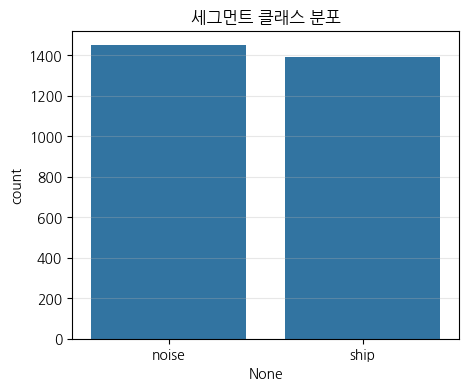

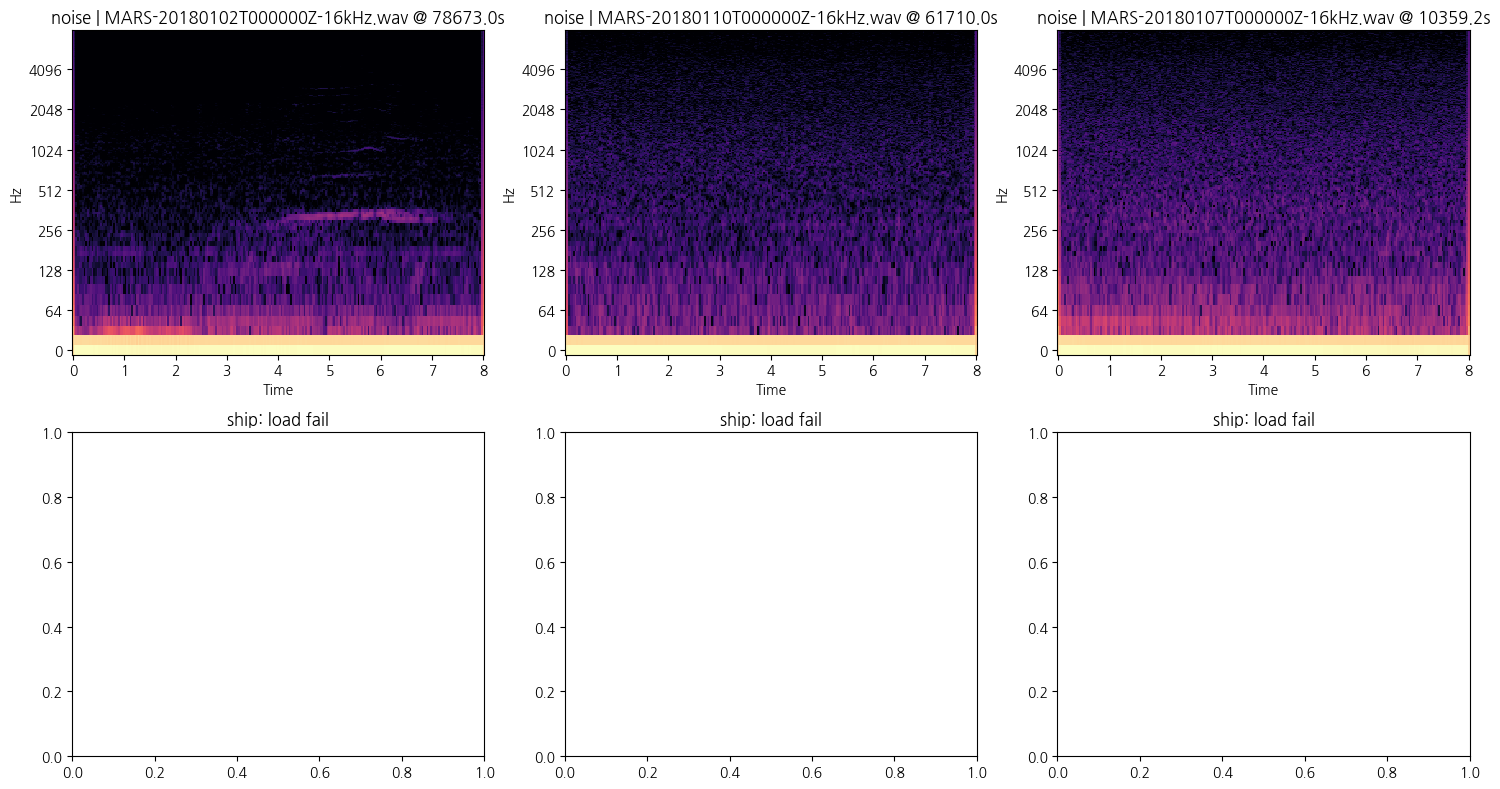


[Split] train=2008 | test=831 (files train/test = 58/15)

YAMNet 로드 ... OK
  임베딩 1000/2008 ... RSS≈1.09 GB
  임베딩 2000/2008 ... RSS≈1.38 GB
 - Xtr:(969, 1024) | RSS≈1.38 GB
[TIMER] 임베딩(Train): 14.80s | RSS≈1.38 GB
 - Xte:(480, 1024) | RSS≈1.39 GB
[TIMER] 임베딩(Test): 4.58s | RSS≈1.39 GB
[임베딩 norm] Train mean=0.570 | std=0.965
[임베딩 norm] Test  mean=0.803 | std=1.095
[class_weight] {np.int64(1): 0.9663137632338787, np.int64(0): 1.0361197110423117}  (0:noise, 1:ship 순서일 가능성)
[TIMER] 모델 학습: 0.00s | RSS≈1.40 GB


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 969
'y' sizes: 2008
'sample_weight' sizes: 2008


In [ ]:
# ==============================================================================
#     ShipsEar 5-class A–E 멀티-버전 비교 하네스 (Embedding 기반 + Fine-tuning 동시비교)
#     - 공통 전처리/세그 생성 → 그룹-계층 분할 → (A) 임베딩 기반 v1~v5
#                                      → (B) 부분 파인튜닝 v6~v8 (end-to-end, staged unfreeze)
#     - 결과 요약표: results/summary.csv, 혼동행렬: results/cm_*.png, AP: results/ap_*.json
# ==============================================================================

print("1) 환경설정/설치 중 ...")
!pip -q install "tensorflow==2.19.0" tensorflow_hub==0.16.1
!pip -q install librosa==0.10.2.post1 soundfile==0.12.1 umap-learn==0.5.6 scikit-learn==1.4.2 psutil==5.9.8 seaborn==0.13.2 joblib==1.4.2

# (선택) 한글 폰트
!apt -yq install fonts-nanum >/dev/null

# ------------------------- Imports & Setup ------------------------------------
import os, re, sys, random, math, gc, time, warnings, shutil, glob, json
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import psutil
import soundfile as sf
import tensorflow as tf
import tensorflow_hub as hub
import librosa, librosa.display
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             roc_auc_score, average_precision_score,
                             balanced_accuracy_score, top_k_accuracy_score, accuracy_score)
from sklearn.model_selection import GroupShuffleSplit

warnings.filterwarnings("ignore", category=UserWarning)
SEED=42
np.random.seed(SEED); random.seed(SEED); tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"]=str(SEED)

if os.path.exists('/usr/share/fonts/truetype/nanum/NanumGothic.ttf'):
    fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
    plt.rc('font', family='NanumGothic'); plt.rcParams['axes.unicode_minus'] = False
    print(" - 폰트 OK: NanumGothic")

def mem(): return f"RSS≈{psutil.Process().memory_info().rss/1024**3:.2f} GB"

# ------------------------- Paths & Config -------------------------------------
BASE="/content"
SHIPSEAR_DRIVE="/content/drive/MyDrive/ShipsEar"    # ← 팀/환경에 맞게 경로 확인
SHIPSEAR=f"{BASE}/ShipsEar_colab"
os.makedirs("results", exist_ok=True); os.makedirs("cache", exist_ok=True); os.makedirs("artifacts", exist_ok=True)

YAM_SR=16000
BASE_CONFIG=dict(
    seg_dur=5.0,               # 5초
    ship_overlap=0.2,          # A–D overlap 비율(0.2→stride=4s)
    noise_overlap=0.0,         # E 중복 최소화
    vad_frame_sec=0.5, vad_hop_sec=0.25, vad_top_db=25.0,
    test_size=0.2, epochs=40, batch=32, lr=5e-4,
    spec_per_class=2,
    umap_max_points=2000,
    max_seg_per_group_per_class=500,
    noise_jitter_sec=0.5,
    topk=2,
    cache_emb=True,            # 임베딩 캐시
)

# ------------------------- 버전 정의 ------------------------------------------
# type: 'emb' (사전 임베딩+헤드) | 'ft' (end-to-end fine-tuning)
VERSIONS = [
    # ----- (A) 임베딩 기반 (지난 하네스 동일) -----
    dict(name="v1_mean_mlp",        type="emb", classifier="mlp",    pooling="mean",    aug=None),
    dict(name="v2_meanstd_mlp",     type="emb", classifier="mlp",    pooling="meanstd", aug=None),
    dict(name="v3_meanstd_logreg",  type="emb", classifier="logreg", pooling="meanstd", aug=None),
    dict(name="v4_meanstd_svm",     type="emb", classifier="svm",    pooling="meanstd", aug=None),
    dict(name="v5_meanstd_mlp_aug", type="emb", classifier="mlp",    pooling="meanstd", aug="light"),

    # ----- (B) 부분 파인튜닝 (도메인 갭 대응) -----
    # 헤드만 먼저 학습 → 전체 Unfreeze 미세조정
    dict(name="v6_ft_mean_headwarmup_unfreeze",    type="ft", pooling="mean",
         warmup_epochs=5, ft_epochs=10, base_lr=3e-4, ft_lr=1e-5, batch_ft=16, aug="light"),

    dict(name="v7_ft_meanstd_headwarmup_unfreeze", type="ft", pooling="meanstd",
         warmup_epochs=5, ft_epochs=10, base_lr=3e-4, ft_lr=1e-5, batch_ft=16, aug="light"),

    # 처음부터 전체 Unfreeze + 매우 작은 LR(완전 미세조정)
    dict(name="v8_ft_meanstd_fullft_tinyLR",       type="ft", pooling="meanstd",
         warmup_epochs=0, ft_epochs=12, base_lr=1e-5, ft_lr=1e-5, batch_ft=16, aug="light"),
]

# ==============================================================================
# 2) 데이터 확보
# ==============================================================================
print("\n2) 데이터 확보 ...")
if os.path.exists(SHIPSEAR_DRIVE):
    if not os.path.exists(SHIPSEAR):
        shutil.copytree(SHIPSEAR_DRIVE, SHIPSEAR, dirs_exist_ok=True)
        print(" - ShipsEar 복사 완료")
    else:
        print(" - ShipsEar 이미 존재")
else:
    print(f" - ShipsEar 드라이브 경로 없음: {SHIPSEAR_DRIVE}")

# ==============================================================================
# 3) 라벨 매핑 & 그룹 키
# ==============================================================================
A_kw = ["fishing","trawler","trawl","mussel","tug","dredger","dredge"]
B_kw = ["motorboat","motor boat","pilot","sailboat","sailing"]
C_kw = ["ferry","passenger"]
D_kw = ["oceanliner","ocean liner","ro-ro","roro","ro_ro","cargo","containership","container","tanker","bulk","liner","oceangoing"]
E_kw = ["background","noise","ambient","no_ship","noship","silence"]

def resolve_ships_ear_class(path):
    name = os.path.basename(path).lower()
    parent = os.path.basename(os.path.dirname(path)).lower()
    txt = f"{parent} {name}"
    def has_any(txt, kws): return any(k in txt for k in kws)
    if has_any(txt, E_kw): return "E"
    if has_any(txt, A_kw): return "A"
    if has_any(txt, B_kw): return "B"
    if has_any(txt, C_kw): return "C"
    if has_any(txt, D_kw): return "D"
    m = re.search(r'\bclass[_\s-]*([abcde])\b', txt)
    if m: return m.group(1).upper()
    return None

def ships_ear_group_key(path):
    base = os.path.basename(path)
    stem = os.path.splitext(base)[0]
    m = re.search(r'(\d{8}[_-]?\d{4})', stem) or re.search(r'(\d{4}[-_]\d{2}[-_]\d{2}[_-]?\d{2}[-_]?\d{2})', stem)
    if m: return m.group(1)
    parent = os.path.basename(os.path.dirname(path))
    toks = re.split(r'[_\-]+', stem)
    prefix = "_".join(toks[:3]) if len(toks)>=3 else stem
    return f"{parent}:{prefix}"

# ==============================================================================
# 4) VAD & 세그 생성
# ==============================================================================
EPS=1e-12

def get_activity_intervals_streaming(file_path, top_db=25.0, frame_sec=0.5, hop_sec=0.25):
    try:
        with sf.SoundFile(file_path) as f:
            sr=f.samplerate; n=len(f)
            F=max(1,int(round(frame_sec*sr))); H=max(1,int(round(hop_sec*sr)))
            # pass1: 최대 dB
            max_db=-np.inf; pos=0
            while pos+F<=n:
                f.seek(pos); y=f.read(frames=F, dtype='float32', always_2d=False)
                if y.ndim>1: y=y.mean(axis=1)
                rms=float(np.sqrt(np.mean(y**2))+EPS)
                db=20*np.log10(rms+EPS)
                if db>max_db: max_db=db
                pos+=H
            if not np.isfinite(max_db): return [], []
            th = max_db - top_db
            # pass2: 병합
            active=[]; in_act=False; cur=0.0; pos=0
            while pos+F<=n:
                f.seek(pos); y=f.read(frames=F, dtype='float32', always_2d=False)
                if y.ndim>1: y=y.mean(axis=1)
                rms=float(np.sqrt(np.mean(y**2))+EPS); db=20*np.log10(rms+EPS)
                t0=pos/sr; t1=(pos+F)/sr
                if db>=th:
                    if not in_act: in_act=True; cur=t0
                else:
                    if in_act: in_act=False; active.append((cur,t1))
                pos+=H
            if in_act: active.append((cur,n/sr))
            # 참고용 비활성
            inactive=[]; last=0.0; dur=n/sr
            for s,e in active:
                if s>last: inactive.append((last,s))
                last=e
            if last<dur: inactive.append((last,dur))
            return active, inactive
    except Exception:
        return [], []

def slice_spans_to_segments(spans, seg_dur, hop):
    segs=[]
    for s,e in spans:
        if e-s < seg_dur: continue
        st=s
        while st <= e - seg_dur + 1e-9:
            segs.append((float(st),))
            st += hop
    return segs

def build_segments_ships_ear(root, cfg):
    seg_dur=cfg["seg_dur"]
    hop_ship = seg_dur*(1-cfg["ship_overlap"])
    hop_noise= seg_dur*(1-cfg["noise_overlap"])
    noise_jitter=cfg.get("noise_jitter_sec", 0.0)
    cap=cfg.get("max_seg_per_group_per_class", None)

    infos=[]; labels=[]; groups=[]
    missing=0
    per_gc_count=defaultdict(int)
    summary = defaultdict(int)

    for fp in glob.glob(os.path.join(root, "**", "*.wav"), recursive=True):
        cls = resolve_ships_ear_class(fp)
        if cls is None:
            missing+=1; continue
        try:
            info=sf.info(fp)
        except:
            continue

        gkey = ships_ear_group_key(fp)
        if cls in ["A","B","C","D"]:
            act,_ = get_activity_intervals_streaming(fp, top_db=cfg["vad_top_db"],
                                                     frame_sec=cfg["vad_frame_sec"], hop_sec=cfg["vad_hop_sec"])
            spans = act; hop = hop_ship
        else: # E
            dur = info.frames/info.samplerate
            spans = [(0.0, dur)]; hop = hop_noise

        segs = slice_spans_to_segments(spans, seg_dur, hop)
        random.shuffle(segs)

        for (st,) in segs:
            if cls == "E" and noise_jitter>0:
                j = random.uniform(-noise_jitter, noise_jitter)
                st = max(0.0, min(st + j, (info.frames/info.samplerate) - seg_dur))
            key=(gkey, cls)
            if cap is not None and per_gc_count[key] >= cap:
                continue
            infos.append((fp, float(st), info.samplerate))
            labels.append(cls)
            groups.append(gkey)
            per_gc_count[key]+=1
            summary[cls]+=1

    return infos, labels, groups, summary, missing

# ==============================================================================
# 5) 오디오 로드/증강/임베딩
# ==============================================================================
def load_segment(info, seg_dur, target_sr=YAM_SR, rms_norm=True):
    fp, start_time, orig_sr = info
    try:
        start=int(start_time*orig_sr); num=int(seg_dur*orig_sr)
        y,_=sf.read(fp, start=start, stop=start+num, dtype='float32', always_2d=False)
        if y.ndim>1: y=y.mean(axis=1)
        if orig_sr!=target_sr:
            y=librosa.resample(y, orig_sr=orig_sr, target_sr=target_sr, res_type="kaiser_fast")
        if rms_norm:
            rms=np.sqrt(np.mean(y**2))+1e-12
            y *= (10**(-20/20))/rms  # -20 dBFS
        return y
    except Exception:
        return None

def augment_wave(y, sr, kind="light"):
    if y is None: return None
    if kind=="light":
        # ±3 dB 게인
        g_db = random.uniform(-3, 3)
        y = y * (10**(g_db/20))
        # ±0.25s 시프트(제로패딩)
        max_shift = int(0.25*sr)
        sh = random.randint(-max_shift, max_shift)
        if sh>0:
            y = np.concatenate([np.zeros(sh, dtype=y.dtype), y[:-sh]])
        elif sh<0:
            y = np.concatenate([y[-sh:], np.zeros(-sh, dtype=y.dtype)])
    return y

def load_yamnet_module():  # 임베딩용
    print("\nYAMNet 로드(emb) ...", end="")
    m=hub.load("https://tfhub.dev/google/yamnet/1")
    print(" OK"); return m

def yamnet_embed(yam, y, pooling="meanstd"):
    if y is None: return None
    try:
        _,emb,_=yam(y)  # (frames, 1024)
        if emb.shape[0]==0: return None
        if pooling=="mean":
            e=tf.reduce_mean(emb, axis=0)
            return e.numpy().astype(np.float32)   # (1024,)
        elif pooling=="meanstd":
            m = tf.reduce_mean(emb, axis=0)
            s = tf.math.reduce_std(emb, axis=0)
            return tf.concat([m,s], axis=0).numpy().astype(np.float32)  # (2048,)
        else:
            raise ValueError("pooling must be 'mean' or 'meanstd'")
    except Exception:
        return None

def embed_many(infos, yam, cfg, pooling="mean", aug=None, cache_key=None, show_every=5000):
    cache_path = None
    if cfg.get("cache_emb", True) and cache_key:
        cache_path = os.path.join("cache", f"emb_{cache_key}.npz")
        if os.path.exists(cache_path):
            z=np.load(cache_path, allow_pickle=True)
            return z["X"], z["keep"]

    X=[]; keep=[]
    for i,info in enumerate(infos,1):
        y=load_segment(info, cfg["seg_dur"], YAM_SR, rms_norm=True)
        if aug:
            y=augment_wave(y, YAM_SR, kind=aug)
        e=yamnet_embed(yam, y, pooling=pooling)
        if e is not None: X.append(e); keep.append(i-1)
        if i%show_every==0:
            print(f"  ... {i}/{len(infos)} | {mem()}")
    X=np.asarray(X, np.float32)
    if cache_path is not None:
        np.savez_compressed(cache_path, X=X, keep=np.array(keep, np.int64))
    return X, keep

# ==============================================================================
# 6) 분할(가능하면 그룹-계층)
# ==============================================================================
def stratified_group_split(y, groups, test_size=0.2, seed=SEED):
    n=len(y)
    try:
        from sklearn.model_selection import StratifiedGroupKFold
        n_splits = max(2, int(round(1.0/test_size)))
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        tr_idx, te_idx = next(sgkf.split(np.zeros(n), y, groups))
        method="StratifiedGroupKFold"
    except Exception:
        gss=GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        tr_idx, te_idx = next(gss.split(np.arange(n), y, groups))
        method="GroupShuffleSplit"
    return tr_idx, te_idx, method

# ==============================================================================
# 7) (A) 임베딩 기반 분류기(MLP/LogReg/SVM)
# ==============================================================================
def build_mlp(input_dim, num_classes, lr):
    reg=tf.keras.regularizers.l2(1e-4)
    inp=tf.keras.Input(shape=(input_dim,), name="emb")
    x=tf.keras.layers.BatchNormalization()(inp)
    x=tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=reg)(x); x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=reg)(x); x=tf.keras.layers.Dropout(0.4)(x)
    out=tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    m=tf.keras.Model(inp,out)
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return m

def train_eval_emb(version, Xtr, ytr, Xte, yte, classes, cfg):
    from joblib import dump
    res={}
    if version["classifier"]=="mlp":
        clf=build_mlp(Xtr.shape[-1], len(classes), lr=cfg["lr"])
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
            tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, min_lr=1e-6),
        ]
        ytr_cat=tf.keras.utils.to_categorical(ytr, num_classes=len(classes))
        yte_cat=tf.keras.utils.to_categorical(yte, num_classes=len(classes))
        cnt_tr=Counter(ytr); total=sum(cnt_tr.values())
        class_weight={cls: total/(len(cnt_tr)*cnt) for cls,cnt in cnt_tr.items()}
        t0=time.time()
        clf.fit(Xtr, ytr_cat, validation_data=(Xte, yte_cat),
                epochs=cfg["epochs"], batch_size=cfg["batch"], verbose=0,
                class_weight=class_weight, callbacks=callbacks)
        probs=clf.predict(Xte, verbose=0); pred=probs.argmax(1)
        model_path=f"artifacts/{version['name']}_mlp.h5"; clf.save(model_path)
        res["artifact"]=model_path; res["time_sec"]=time.time()-t0
    else:
        from sklearn.linear_model import LogisticRegression
        from sklearn.svm import SVC
        scaler=StandardScaler().fit(Xtr)
        Xtr_s=scaler.transform(Xtr); Xte_s=scaler.transform(Xte)
        t0=time.time()
        if version["classifier"]=="logreg":
            clf=LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1)
            clf.fit(Xtr_s, ytr); probs=clf.predict_proba(Xte_s); pred=probs.argmax(1)
        else:
            clf=SVC(C=2.0, kernel='rbf', probability=True, class_weight='balanced')
            clf.fit(Xtr_s, ytr); probs=clf.predict_proba(Xte_s); pred=probs.argmax(1)
        res["time_sec"]=time.time()-t0
        import joblib
        model_path=f"artifacts/{version['name']}_{version['classifier']}.joblib"
        scaler_path=f"artifacts/{version['name']}_scaler.joblib"
        joblib.dump(clf, model_path); joblib.dump(scaler, scaler_path)
        res["artifact"]=model_path; res["scaler"]=scaler_path

    true=yte
    res["acc"]=accuracy_score(true, pred)
    res["bal_acc"]=balanced_accuracy_score(true, pred)
    res["macroF1"]=f1_score(true, pred, average='macro')
    try:
        yte_cat=tf.keras.utils.to_categorical(true, num_classes=len(classes))
        res["macroROC"]=roc_auc_score(yte_cat, probs, average='macro', multi_class='ovr')
    except Exception:
        res["macroROC"]=np.nan
    try:
        res["topk"]=top_k_accuracy_score(true, probs, k=BASE_CONFIG["topk"], labels=range(len(classes)))
    except Exception:
        res["topk"]=np.nan
    ap={}
    for i,lab in enumerate(classes):
        y_bin=(true==i).astype(int)
        if 0<y_bin.sum()<len(y_bin): ap[lab]=float(average_precision_score(y_bin, probs[:,i]))
        else: ap[lab]=float("nan")
    res["ap_per_class"]=ap
    res["cm"]=confusion_matrix(true, pred)
    return res

# ==============================================================================
# 8) (B) 부분 파인튜닝 — tf.data 스트리밍 + staged unfreeze
# ==============================================================================
def make_wave_ds(infos, y_enc, cfg, batch, shuffle=False, aug=None):
    L=int(YAM_SR*cfg["seg_dur"])

    def gen():
        for info, y in zip(infos, y_enc):
            wav=load_segment(info, cfg["seg_dur"], YAM_SR, rms_norm=True)
            if aug: wav=augment_wave(wav, YAM_SR, kind=aug)
            if wav is None:
                continue
            # 잘못된 길이는 패드/트림
            if len(wav)<L:
                pad=np.zeros(L, dtype=np.float32); pad[:len(wav)]=wav
                wav=pad
            elif len(wav)>L:
                wav=wav[:L]
            yield wav.astype(np.float32), np.int32(y)

    ds=tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            tf.TensorSpec(shape=(L,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    if shuffle:
        ds=ds.shuffle(buffer_size=min(10000, len(infos)))
    ds=ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

def build_yamnet_ft_model(num_classes, pooling="meanstd", trainable=False, lr=3e-4):
    L=None  # 가변 가능하지만 여기서는 고정 길이 입력을 사용
    wave_in=tf.keras.Input(shape=(int(YAM_SR*BASE_CONFIG["seg_dur"]),), dtype=tf.float32, name="wave")
    # TF-Hub KerasLayer (멀티 아웃풋: scores, embeddings, spectrogram)
    yam_layer=hub.KerasLayer("https://tfhub.dev/google/yamnet/1", trainable=trainable, name="yamnet")
    out = yam_layer(wave_in)
    # 출력 해석 (tuple 또는 dict 대비)
    if isinstance(out, (list, tuple)):
        scores, embeddings = out[0], out[1]            # (B, T, 1024)
    elif isinstance(out, dict):
        embeddings = out.get("embedding") or out.get("embeddings")
        scores = out.get("scores", None)
    else:
        raise ValueError("Unexpected YAMNet outputs")

    # 풀링
    m = tf.reduce_mean(embeddings, axis=1)             # (B, 1024)
    if pooling=="meanstd":
        s = tf.math.reduce_std(embeddings, axis=1)     # (B, 1024)
        feat = tf.keras.layers.Concatenate()([m, s])   # (B, 2048)
    else:
        feat = m                                       # (B, 1024)

    # 헤드
    x=tf.keras.layers.BatchNormalization()(feat)
    x=tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x=tf.keras.layers.Dropout(0.4)(x)
    out=tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model=tf.keras.Model(wave_in, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

def train_eval_ft(version, Xtr_infos, ytr, Xte_infos, yte, classes):
    # 데이터셋
    ds_tr_warm = make_wave_ds(Xtr_infos, ytr, BASE_CONFIG,
                              batch=version.get("batch_ft", 16),
                              shuffle=True, aug=version.get("aug", None))
    ds_tr_ft   = make_wave_ds(Xtr_infos, ytr, BASE_CONFIG,
                              batch=version.get("batch_ft", 16),
                              shuffle=True, aug=version.get("aug", None))
    ds_te      = make_wave_ds(Xte_infos, yte, BASE_CONFIG,
                              batch=version.get("batch_ft", 16),
                              shuffle=False, aug=None)

    # 1) 헤드만 워밍업 (yamnet trainable=False)
    warmup_epochs=version.get("warmup_epochs", 5)
    base_lr=version.get("base_lr", 3e-4)
    ft_lr  =version.get("ft_lr",   1e-5)
    pooling=version.get("pooling", "meanstd")

    t0=time.time()
    model=build_yamnet_ft_model(len(classes), pooling=pooling, trainable=False, lr=base_lr)
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss'),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-6),
    ]

    if warmup_epochs>0:
        model.fit(ds_tr_warm, validation_data=ds_te, epochs=warmup_epochs, verbose=0, callbacks=callbacks)

    # 2) 전체 Unfreeze or 바로 Full-FT
    ft_epochs=version.get("ft_epochs", 10)
    # unfreeze
    for lyr in model.layers:
        if "yamnet" in lyr.name:
            lyr.trainable=True
    # re-compile with tiny LR
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ft_lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    model.fit(ds_tr_ft, validation_data=ds_te, epochs=ft_epochs, verbose=0, callbacks=callbacks)

    # 평가
    probs = model.predict(ds_te, verbose=0)
    pred  = probs.argmax(1)
    true  = np.fromiter((y for _, y in make_wave_ds(Xte_infos, yte, BASE_CONFIG, batch=version.get("batch_ft",16))), dtype=np.int32)

    res={}
    res["artifact"]=f"artifacts/{version['name']}_yamnet_ft.h5"
    model.save(res["artifact"])
    res["time_sec"]=time.time()-t0
    res["acc"]=accuracy_score(true, pred)
    res["bal_acc"]=balanced_accuracy_score(true, pred)
    res["macroF1"]=f1_score(true, pred, average='macro')
    try:
        yte_cat=tf.keras.utils.to_categorical(true, num_classes=len(classes))
        res["macroROC"]=roc_auc_score(yte_cat, probs, average='macro', multi_class='ovr')
    except Exception:
        res["macroROC"]=np.nan
    try:
        res["topk"]=top_k_accuracy_score(true, probs, k=BASE_CONFIG["topk"], labels=range(len(classes)))
    except Exception:
        res["topk"]=np.nan
    ap={}
    for i,lab in enumerate(classes):
        y_bin=(true==i).astype(int)
        if 0<y_bin.sum()<len(y_bin): ap[lab]=float(average_precision_score(y_bin, probs[:,i]))
        else: ap[lab]=float("nan")
    res["ap_per_class"]=ap
    res["cm"]=confusion_matrix(true, pred)
    return res

# ==============================================================================
# 9) 파이프라인 실행 (한 번 분할 → 모든 버전 공통 비교)
# ==============================================================================
def run_all(config=BASE_CONFIG, versions=VERSIONS):
    # 세그 생성
    print("\n[STEP] 세그먼트 생성 ...")
    infos, labels, groups, summary, missing = build_segments_ships_ear(SHIPSEAR, config)
    print(" - 클래스별 개수:", dict(summary), "| 매핑 실패:", missing)

    # 감사
    n_files=len(set([i[0] for i in infos])); n_groups=len(set(groups))
    total_h=(len(infos)*config["seg_dur"])/3600.0
    print(f" - 세그:{len(infos)} | 파일≈{n_files} | 그룹≈{n_groups} | 총길이≈{total_h:.2f} h")

    # 라벨/그룹
    le=LabelEncoder(); y_all=le.fit_transform(labels)   # ['A','B','C','D','E']
    g_arr=np.array(groups)

    # 분할(가능하면 그룹-계층)
    tr_idx, te_idx, method = stratified_group_split(y_all, g_arr, config["test_size"])
    print(f"[Split] method={method} | train={len(tr_idx)} | test={len(te_idx)} | "
          f"그룹수 train/test={len(set(g_arr[tr_idx]))}/{len(set(g_arr[te_idx]))}")

    Xtr_infos=[infos[i] for i in tr_idx]; ytr=y_all[tr_idx]
    Xte_infos=[infos[i] for i in te_idx]; yte=y_all[te_idx]
    classes=list(le.classes_)

    # YAMNet(임베딩 기반 공유)
    yam=None
    if any(v["type"]=="emb" for v in versions):
        yam=load_yamnet_module()

    all_results=[]
    for v in versions:
        print(f"\n================= {v['name']} =================")
        if v["type"]=="emb":
            pooling=v.get("pooling","mean")
            aug=v.get("aug", None)
            cache_key=f"{v['name']}_{pooling}_aug{aug}_{config['seg_dur']}s"
            print(" - 임베딩(Train) ...", end="")
            Xtr, keep_tr = embed_many(Xtr_infos, yam, config, pooling=pooling, aug=aug, cache_key=cache_key+"_tr")
            ytr_v=ytr[keep_tr]; print(" OK", Xtr.shape)
            print(" - 임베딩(Test) ...", end="")
            Xte, keep_te = embed_many(Xte_infos, yam, config, pooling=pooling, aug=None, cache_key=cache_key+"_te")
            yte_v=yte[keep_te]; print(" OK", Xte.shape)

            res=train_eval_emb(v, Xtr, ytr_v, Xte, yte_v, classes, cfg=config)

        else:  # 'ft'
            res=train_eval_ft(v, Xtr_infos, ytr, Xte_infos, yte, classes)

        # 공통: 결과 저장/집계
        row=dict(
            version=v['name'], type=v['type'],
            pooling=v.get('pooling','-'), classifier=v.get('classifier','ft'),
            aug=(v.get('aug') or "none"),
            acc=res["acc"], bal_acc=res["bal_acc"], macroF1=res["macroF1"],
            macroROC=res["macroROC"], topk=res["topk"],
            time_sec=res["time_sec"], artifact=res.get("artifact","")
        )
        all_results.append((row, res))

        # 혼동행렬 저장
        cm=res["cm"]
        plt.figure(figsize=(5.5,4.8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.xlabel("예측"); plt.ylabel("실제"); plt.title(f"CM — {v['name']}")
        plt.tight_layout()
        plt.savefig(f"results/cm_{v['name']}.png", dpi=150)
        plt.close()

        # AP per class 저장
        with open(f"results/ap_{v['name']}.json","w") as f:
            json.dump(res["ap_per_class"], f, indent=2)

    # 요약 표
    df=pd.DataFrame([r[0] for r in all_results])
    df_sorted=df.sort_values(["macroF1","bal_acc","acc"], ascending=False)
    df_sorted.to_csv("results/summary.csv", index=False)
    print("\n[SUMMARY]")
    print(df_sorted.to_string(index=False))
    print("\n결과 파일:")
    print(" - results/summary.csv")
    print(" - results/cm_*.png")
    print(" - results/ap_*.json")
    print(" - artifacts/* (모델)")

run_all(BASE_CONFIG, VERSIONS)
print("\n🎉 완료 — 버전별 결과는 results/summary.csv 와 results/cm_*.png, artifacts/* 에 저장됩니다.")


In [ ]:
# ================================ OOD 평가 모듈 =================================
# 이 블록은 기존 파이프라인에서 학습이 끝난 후에 붙여 실행하세요.
# 필요 전역: YAMNET_SAMPLE_RATE, CONFIG, yamnet, clf(학습된 분류기), le,
#            Xtr/ytr, Xte/yte, Xtr_info/Xte_info (option), BASE 경로
# ==============================================================================

import os, subprocess, random, math, gc, glob, re
import numpy as np
import pandas as pd
import soundfile as sf
import librosa, librosa.display
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve

# ---------- 1) Git에서 OOD 샘플 오디오 가볍게 수집 ----------
OOD_ROOT = f"{BASE}/ood_audio_corpus"
os.makedirs(OOD_ROOT, exist_ok=True)

OOD_REPOS = [
    # 소형 예제/테스트 오디오가 비교적 들어있는 경우가 많음
    ("https://github.com/openai/whisper.git",          "whisper"),
    ("https://github.com/pytorch/audio.git",           "torchaudio"),
    ("https://github.com/iver56/audiomentations.git",  "audiomentations"),
    ("https://github.com/huggingface/transformers.git","transformers"),
]

def clone_if_needed(url, name):
    dst = os.path.join(OOD_ROOT, name)
    if not os.path.exists(dst):
        try:
            subprocess.run(["git","clone","--depth","1",url,dst], check=True, capture_output=True)
            print(f" - OK: {url}")
        except Exception as e:
            print(f" - FAIL: {url} ({e})")
    else:
        print(f" - already exists: {url}")
    return dst

print("\n[OOD] 리포지토리 수집 ...")
repo_dirs = [clone_if_needed(u,n) for (u,n) in OOD_REPOS]

# 오디오 확장자 패턴(넓게 잡되 개수 제한)
EXTS = (".wav",".flac",".ogg",".mp3",".m4a",".aac",".wma",".aiff",".aif",".aifc",".au",".mp2",".opus")
def find_audio_files(roots, max_total=200):
    all_files=[]
    for r in roots:
        for ext in EXTS:
            all_files += glob.glob(os.path.join(r, "**", f"*{ext}"), recursive=True)
    # 너무 많은 경우 샘플링
    if len(all_files) > max_total:
        random.shuffle(all_files)
        all_files = all_files[:max_total]
    return all_files

ood_files = find_audio_files(repo_dirs, max_total=250)
print(f" - 수집된 OOD 원본 파일: {len(ood_files)}")

# ---------- 2) OOD 세그먼트(5초) 스트리밍 생성 ----------
def stream_segments_for_ood(file_path, seg_dur=5.0, stride=5.0, cap_per_file=6):
    """librosa.load 없이 스트리밍으로 5초 구간을 균일 스트라이드로 최대 cap만 추출"""
    segs=[]
    try:
        info = sf.info(file_path)
        total = info.frames
        sr    = info.samplerate
        if info.duration < seg_dur: return segs

        # 균일 스트라이드로 시작점 후보 생성
        starts = np.arange(0, info.duration - seg_dur + 1e-9, stride)
        random.shuffle(starts)
        for st in starts[:cap_per_file]:
            segs.append((file_path, float(st), sr))
    except:
        pass
    return segs

# 너무 많이 뽑지 않도록 전체 cap (예: 800 세그먼트)
OOD_GLOBAL_CAP = 800
ood_segments=[]
for f in ood_files:
    segs = stream_segments_for_ood(f, seg_dur=CONFIG["segment_duration"], stride=CONFIG["segment_duration"], cap_per_file=6)
    ood_segments.extend(segs)
    if len(ood_segments) >= OOD_GLOBAL_CAP: break
print(f" - 생성된 OOD 세그먼트: {len(ood_segments)}")

# ---------- 3) OOD 임베딩 ----------
def load_and_process_segment(info, duration, target_sr, rms_norm=True):
    file_path, start_time, orig_sr = info
    try:
        start = int(start_time*orig_sr); num = int(duration*orig_sr)
        y, _ = sf.read(file_path, start=start, stop=start+num, dtype='float32', always_2d=False)
        if y.ndim>1: y = y.mean(axis=1)
        if orig_sr != target_sr:
            y = librosa.resample(y, orig_sr=orig_sr, target_sr=target_sr, res_type="kaiser_fast")
        if rms_norm:
            rms = np.sqrt(np.mean(y**2))+1e-12
            y = y * ((10**(-20/20))/rms)
        return y
    except:
        return None

def yamnet_embed_batch(infos, seg_dur=5.0, batch=128):
    X=[]; rms_list=[]; kept=[]
    for i,info in enumerate(infos):
        y = load_and_process_segment(info, seg_dur, YAMNET_SAMPLE_RATE, rms_norm=True)
        if y is None: continue
        # RMS(정규화 전에)도 저장해 에너지 편향 분석
        y_raw = load_and_process_segment(info, seg_dur, YAMNET_SAMPLE_RATE, rms_norm=False)
        rms_list.append(float(np.sqrt(np.mean(y_raw**2))+1e-12) if y_raw is not None else np.nan)
        try:
            _, emb, _ = yamnet(y)
            if emb.shape[0] == 0: continue
            X.append(tf.reduce_mean(emb, axis=0).numpy())
            kept.append(info)
        except:
            continue
        if (i+1)%500==0:
            print(f"  OOD 임베딩 {i+1}/{len(infos)}...")
    return np.asarray(X, dtype=np.float32), np.asarray(rms_list), kept

print("\n[OOD] 임베딩 추출 ...")
Xood, rms_ood, kept_ood = yamnet_embed_batch(ood_segments, seg_dur=CONFIG["segment_duration"])
print(f" - Xood:{Xood.shape}")

if Xood.shape[0] == 0:
    print("경고: OOD 임베딩이 비었습니다. 리포 소스나 max_total, cap을 조정해보세요.")

# ---------- 4) 임계값 선택(검증셋 TPR=95%) & ID/OOD FPR 비교 ----------
# 학습에 사용한 train에서 validation을 분리(간단히 10% hold-out)
def split_val_from_train(Xtr, ytr_onehot, val_ratio=0.1, seed=42):
    n = len(Xtr)
    idx = np.arange(n)
    rng = np.random.RandomState(seed)
    rng.shuffle(idx)
    k = max(1, int(round(n*val_ratio)))
    val_idx = idx[:k]; tr_idx = idx[k:]
    return Xtr[tr_idx], ytr_onehot[tr_idx], Xtr[val_idx], ytr_onehot[val_idx]

Xtr_fit, ytr_fit, Xval, yval = split_val_from_train(Xtr, ytr, val_ratio=0.1, seed=SEED)

# 재학습 없이 clf를 재사용하되, val 확률만 새로 추정
p_val = clf.predict(Xval, verbose=0)
p_te  = clf.predict(Xte,  verbose=0)

ship_idx = list(le.classes_).index('ship')
yval_bin = (yval.argmax(1)==ship_idx).astype(int)
yte_bin  = (yte.argmax(1)==ship_idx).astype(int)

def select_threshold_by_tpr(y_true_bin, y_score, target_tpr=0.95):
    fpr, tpr, thr = roc_curve(y_true_bin, y_score)
    # TPR이 target에 가장 근접한 점의 threshold
    j = np.argmin(np.abs(tpr - target_tpr))
    return float(thr[j]), float(tpr[j]), float(fpr[j])

tau, tpr_at_tau, fpr_at_tau = select_threshold_by_tpr(yval_bin, p_val[:,ship_idx], target_tpr=0.95)
print(f"\n[임계값] TPR@val≈95% → τ={tau:.4f} (val TPR={tpr_at_tau:.3f}, val FPR={fpr_at_tau:.3f})")

# ID-테스트 FPR / OOD FPR
fpr_id  = float(((p_te[:,ship_idx] >= tau) & (yte_bin==0)).mean()) if len(yte_bin)>0 else float('nan')

p_ood = clf.predict(Xood, verbose=0) if Xood.shape[0]>0 else np.zeros((0,len(le.classes_)),dtype=np.float32)
fpr_ood = float((p_ood[:,ship_idx] >= tau).mean()) if p_ood.shape[0]>0 else float('nan')

print(f"[FPR] ID(Test) FPR@τ={fpr_id:.4f} | OOD FPR@τ={fpr_ood:.4f}")

# ---------- 5) 시각화: 확률 분포 / ROC-PR / 에너지 편향 ----------
# (a) 확률 히스토그램
plt.figure(figsize=(7,5))
sns.kdeplot(p_te[yte_bin==1, ship_idx], label="ID: ship", fill=True, alpha=0.3)
sns.kdeplot(p_te[yte_bin==0, ship_idx], label="ID: noise", fill=True, alpha=0.3)
if p_ood.shape[0]>0:
    sns.kdeplot(p_ood[:, ship_idx], label="OOD (others)", fill=True, alpha=0.3)
plt.axvline(tau, color='k', ls='--', label=f"τ={tau:.2f}")
plt.title("Ship 확률 분포(ID vs OOD)"); plt.xlabel("P(ship)"); plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# (b) ROC/PR (ID 기준)
fpr_id_curve, tpr_id_curve, _ = roc_curve(yte_bin, p_te[:,ship_idx])
roc_auc_id = auc(fpr_id_curve, tpr_id_curve)
prec, rec, _ = precision_recall_curve(yte_bin, p_te[:,ship_idx])
auprc = average_precision_score(yte_bin, p_te[:,ship_idx])

plt.figure(figsize=(11,4))
plt.subplot(1,2,1)
plt.plot(fpr_id_curve, tpr_id_curve, lw=2, label=f"AUC={roc_auc_id:.3f}")
plt.plot([0,1],[0,1],'--',alpha=0.4)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (ID Test)"); plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR (ID Test), AUPRC={auprc:.3f}")
plt.grid(True, alpha=0.3)
plt.show()

# (c) 에너지 decile 별 FPR (ID-Noise vs OOD)
def segment_rms(info, seg_dur=5.0):
    y = load_and_process_segment(info, seg_dur, YAMNET_SAMPLE_RATE, rms_norm=False)
    if y is None: return np.nan
    return float(np.sqrt(np.mean(y**2))+1e-12)

# ID-Noise RMS와 확률
id_noise_idx = np.where(yte_bin==0)[0]
rms_id_noise = np.array([segment_rms(Xte_info[i], CONFIG["segment_duration"]) if 'Xte_info' in globals() else np.nan
                         for i in id_noise_idx])
prob_id_noise = p_te[id_noise_idx, ship_idx]

def fpr_by_rms_decile(rms_arr, prob_arr, tau, n_bins=10):
    valid = np.isfinite(rms_arr)
    rms_arr, prob_arr = rms_arr[valid], prob_arr[valid]
    if len(rms_arr) < 10:
        return None
    qs = np.quantile(rms_arr, np.linspace(0,1,n_bins+1))
    bins = np.digitize(rms_arr, qs[1:-1], right=True)
    out=[]
    for b in range(n_bins):
        m = (bins==b)
        if m.sum()==0: out.append(np.nan)
        else: out.append(float((prob_arr[m] >= tau).mean()))
    return out, qs

ood_rms = np.zeros(0);
if len(kept_ood)>0:
    ood_rms = np.array([segment_rms(info, CONFIG["segment_duration"]) for info in kept_ood])

res_id = fpr_by_rms_decile(rms_id_noise, prob_id_noise, tau, n_bins=10)
res_ood = (None, None)
if len(ood_rms)>0:
    res_ood = fpr_by_rms_decile(ood_rms, p_ood[:,ship_idx], tau, n_bins=10)

if res_id is not None:
    fpr_bins_id, qs_id = res_id
    plt.figure(figsize=(7,4))
    plt.plot(range(1,11), fpr_bins_id, marker='o', label='ID-Noise')
    if isinstance(res_ood[0], list):
        plt.plot(range(1,11), res_ood[0], marker='o', label='OOD')
    plt.xticks(range(1,11)); plt.xlabel("RMS decile (낮음→높음)")
    plt.ylabel(f"FPR@τ"); plt.title("에너지 구간별 FPR (낮을수록 좋음)")
    plt.grid(True, alpha=0.3); plt.legend(); plt.show()
else:
    print("RMS decile 분석을 위한 유효 표본이 부족합니다.")

print("\n[요약]")
print(f" - 임계값 τ(Val TPR≈95%): {tau:.3f}")
print(f" - FPR(ID-noise)@τ: {fpr_id:.4f}")
print(f" - FPR(OOD)@τ: {fpr_ood:.4f} (낮을수록 좋음)")
print(f" - ROC-AUC(ID test): {roc_auc_id:.3f}, AUPRC(ID test): {auprc:.3f}")
print(" - 그래프: 확률분포/ROC/PR/에너지-디사일 FPR으로, 에너지-편향 여부를 함께 점검")
# ==============================================================================
